# About the notebook
This script contains the results ofthree different ensemble methods (leave-one-out cross-validation, 10-fold cross-validation and bootstrapping) to get more robust predictions in my high dimensional dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,accuracy_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Read in the data

In [2]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "MIDPOINT"
amplitude = "FFT"

In [3]:
# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

In [4]:
# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

In [5]:
# concat breast cancer and healthy
data = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude')) | (data.columns.str.startswith('nucleosome_spacing'))]
data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,0.921859,0.999899,5.964870,148.0,0.993629,0.999585,15.140059,192.0,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,0.966934,1.000200,19.353707,192.0,1.033113,1.000039,9.433198,240.0,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,1.161236,0.999987,11.505221,213.0,1.115174,0.999805,17.278634,192.0,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,1.027811,0.999776,20.178665,192.0,1.038958,1.000246,3.898227,160.0,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,1.118326,1.000246,10.611337,213.0,1.166457,0.999947,1.834101,213.0,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [6]:
#scale data
scaled_data = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data[features])
scaled_data[features] = scaler.transform(scaled_data[features])

scaled_data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,-1.587964,-0.402804,-1.431977,-2.181180,-1.235524,-2.211313,0.879156,-0.406840,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,-0.575681,1.081786,0.380465,-0.469377,-0.233665,0.148223,-0.184884,1.386579,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,3.787805,0.031149,-0.681981,0.347620,1.848499,-1.066968,1.277891,-0.406840,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,0.791448,-1.014266,0.492140,-0.469377,-0.085350,1.227604,-1.216876,-1.602453,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,2.824170,1.308605,-0.802986,0.347620,3.149750,-0.327229,-1.601730,0.377780,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


# Functions

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a) #standard error of the mean
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [8]:
def plot_roc_curve(tpr,fpr,AUC):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % AUC)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Leave-one-out cross-validation functions

In [9]:
def LR_loo(data,pca_flag,default_flag,all_features):

    X = data[all_features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.coef_[0], index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)

    return(all_performance,feature_importances)

In [10]:
def RF_loo(data,pca_flag,default_flag,all_features):

    X = data[features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)
    
    return(all_performance,feature_importances)

In [11]:
def GBC_loo(data,pca_flag,default_flag,all_features):

    X = data[features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)
    
    return(all_performance,feature_importances)

## Bootstrapping functions

In [12]:
def RF_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):

    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)
    
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)

    return(all_performance,feature_importances)

In [13]:
def LR_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)
    
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.coef_[0], index=all_features)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance,feature_importances)

In [14]:
def GBC_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):

    all_performance = pd.DataFrame()
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)

    return(all_performance)

## 10-fold cross-validation functions

In [15]:
def RF_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

In [16]:
def LR_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

In [17]:
def GBC_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

# Leave one out

In [18]:
# Logistic Regression
lr_loo_perf,LR_LOO_final_fi = LR_loo(scaled_data,False,False,features)
lr_loo_perf

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.4629629629629629...
accuracy                                             0.787037
auc                                                   0.88546
dtype: object

In [19]:
# features with highest absolute values over all iterations
np.abs(LR_LOO_final_fi.mean(axis=1)).sort_values(ascending=False).head(10)

central_coverage_PAX5      0.631269
central_coverage_MAF       0.353792
central_coverage_CEBPB     0.292021
central_coverage_ZNF384    0.173284
amplitude190_SCRT2         0.099086
mean_coverage_ZFHX2        0.088451
amplitude190_ZNF574        0.047345
amplitude190_ZNF444        0.046030
amplitude190_KLF6          0.033898
amplitude190_MBD2          0.010642
dtype: float64

In [20]:
# features with lowest absolute values over all iterations
LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).tail(10)

amplitude190_ZFX         0.000000
central_coverage_RBPJ    0.000000
amplitude190_FOS        -0.000213
mean_coverage_GFI1B     -0.000447
mean_coverage_HIF3A     -0.000635
amplitude190_SMAD3      -0.006757
amplitude190_KLF6       -0.033898
amplitude190_ZNF444     -0.046030
amplitude190_ZNF574     -0.047345
mean_coverage_ZFHX2     -0.088451
dtype: float64

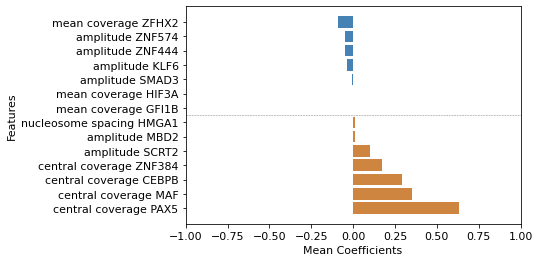

In [21]:
# Final plot for thesis

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

plt.rcParams.update({'font.size': 11})
d = LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).head(7)

d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'amplitude190_ZNF574': 'amplitude ZNF574'})
d = d.rename(index={'amplitude190_ZNF444': 'amplitude ZNF444'})
d = d.rename(index={'amplitude190_KLF6': 'amplitude KLF6'})
d = d.rename(index={'amplitude190_SMAD3': 'amplitude SMAD3'})
d = d.rename(index={'mean_coverage_ZFHX2': 'mean coverage ZFHX2'})
d = d.rename(index={'mean_coverage_HIF3A': 'mean coverage HIF3A'})
d = d.rename(index={'mean_coverage_GFI1B': 'mean coverage GFI1B'})

#plt.title('Logistic Regression with leave-one-out cross-validation')
plt.barh(d.index,d,color="peru")

d = LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).tail(7)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'amplitude190_ZNF574': 'amplitude ZNF574'})
d = d.rename(index={'amplitude190_ZNF444': 'amplitude ZNF444'})
d = d.rename(index={'amplitude190_KLF6': 'amplitude KLF6'})
d = d.rename(index={'amplitude190_SMAD3': 'amplitude SMAD3'})
d = d.rename(index={'mean_coverage_ZFHX2': 'mean coverage ZFHX2'})
d = d.rename(index={'mean_coverage_HIF3A': 'mean coverage HIF3A'})
d = d.rename(index={'mean_coverage_GFI1B': 'mean coverage GFI1B'})

plt.barh(d.index,d,color="steelblue")

plt.axhline(y=6.5, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Mean Coefficients')
plt.ylabel('Features')
plt.xlim(-1,1)

outfile = "thesis_plots/LogisticRegression_LOO.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [22]:
# RF scaled data
rf_loo_perf,fi = RF_loo(scaled_data,False,False,features)
rf_loo_perf

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5370370370370371...
accuracy                                             0.777778
auc                                                   0.88786
dtype: object

In [23]:
# GBC scaled data
gbc_loo_perf,fi = GBC_loo(data,False,False,features)
gbc_loo_perf

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.4629629629629629...
accuracy                                             0.805556
auc                                                  0.909465
dtype: object

# Bootstrapping

In [24]:
# Logistic Regression
lr_bootstrap_perf, fi = LR_bootstrap(scaled_data,False,1000,False,features)

print("Accuracy min", lr_bootstrap_perf['accuracy'].min(), "mean", lr_bootstrap_perf['accuracy'].mean(), "max", lr_bootstrap_perf['accuracy'].max())
print("AUROC min", lr_bootstrap_perf['auc'].min(), "mean", lr_bootstrap_perf['auc'].mean(), "max", lr_bootstrap_perf['auc'].max())

Accuracy min 0.5238095238095238 mean 0.7461328744758898 max 0.925
AUROC min 0.58 mean 0.8212367379734258 max 0.9769736842105263


In [25]:
print(lr_bootstrap_perf['accuracy'].var())
lr_bootstrap_perf['accuracy'].describe()

0.0038736384399284244


count    1000.000000
mean        0.746133
std         0.062239
min         0.523810
25%         0.702703
50%         0.750000
75%         0.789780
max         0.925000
Name: accuracy, dtype: float64

In [26]:
print(lr_bootstrap_perf['auc'].var())
lr_bootstrap_perf['auc'].describe()

0.003806739217353715


count    1000.000000
mean        0.821237
std         0.061699
min         0.580000
25%         0.781125
50%         0.825708
75%         0.864766
max         0.976974
Name: auc, dtype: float64

In [27]:
mean_confidence_interval(lr_bootstrap_perf['auc'], confidence=0.95)

(0.8212367379734258, 0.8174080396948011, 0.8250654362520504)

central coverage PAX5        0.470895
central coverage CEBPB       0.236040
central coverage MAF         0.232919
central coverage ZNF384      0.074383
amplitude SCRT2              0.051485
nucleosome spacing HMGA1     0.035015
central coverage ZNF444      0.033881
amplitude ARID3A             0.031274
amplitude NFATC3             0.026644
amplitude WT1                0.021072
central coverage FLI1        0.021022
central coverage FOXK2       0.020768
amplitude MBD2               0.020175
amplitude OSR2               0.020093
amplitude FOXK1              0.017757
amplitude AHR                0.014907
amplitude190_TET3            0.013274
amplitude RBPJ               0.012918
amplitude HES1               0.012784
nucleosome spacing ZNF768    0.012757
dtype: float64


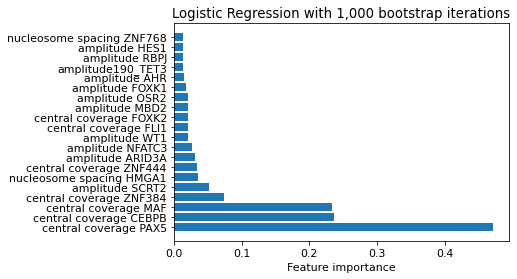

In [28]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

d = fi.mean(axis=1).sort_values(ascending=False).head(20)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'central_coverage_ZNF444': 'central coverage ZNF444'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'central_coverage_FOXK2': 'central coverage FOXK2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_FLI1': 'central coverage FLI1'})
d = d.rename(index={'amplitude190_FOXK1': 'amplitude FOXK1'})
d = d.rename(index={'amplitude190_WT1': 'amplitude WT1'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_HES1': 'amplitude HES1'})
d = d.rename(index={'central_coverage_ZNF121': 'central coverage ZNF121'})
d = d.rename(index={'amplitude190_AHR': 'amplitude AHR'})
print(d)

outfile = "thesis_plots/LogisticRegression_bootstrap.pdf"

plt.title('Logistic Regression with 1,000 bootstrap iterations')
plt.barh(d.index,d)

plt.xlabel('Feature importance')

plt.savefig(outfile,bbox_inches='tight')

In [29]:
# Logistic Regression with PCA
#lr_bootstrap_PCA_perf,fi = LR_bootstrap(scaled_data,True,1000,False,features)

#print("Accuracy min", lr_bootstrap_PCA_perf['accuracy'].min(), "mean", lr_bootstrap_PCA_perf['accuracy'].mean(), "max", lr_bootstrap_PCA_perf['accuracy'].max())
#print("AUROC min", lr_bootstrap_PCA_perf['auc'].min(), "mean", lr_bootstrap_PCA_perf['auc'].mean(), "max", lr_bootstrap_PCA_perf['auc'].max())

#lr_bootstrap_PCA_perf['auc'].mean()

In [30]:
# Random Forest
rf_bootstrap_perf,fi = RF_bootstrap(scaled_data,False,1000,False,features)

In [31]:
print(rf_bootstrap_perf['accuracy'].var())
rf_bootstrap_perf['accuracy'].describe()

0.005044967208808678


count    1000.000000
mean        0.751293
std         0.071028
min         0.363636
25%         0.710526
50%         0.756098
75%         0.804878
max         0.944444
Name: accuracy, dtype: float64

In [32]:
print(rf_bootstrap_perf['auc'].var())
rf_bootstrap_perf['auc'].describe()

0.0031399313237985838


count    1000.000000
mean        0.862056
std         0.056035
min         0.625668
25%         0.830770
50%         0.865098
75%         0.902632
max         0.990431
Name: auc, dtype: float64

In [33]:
# Random Forest with PCA
#rf_bootstrap_PCA_perf,fi = RF_bootstrap(scaled_data,True,1000,False)
#rf_bootstrap_PCA_perf['auc'].mean()

In [34]:
# Gradient Boosting
gbc_bootstrap_perf = GBC_bootstrap(scaled_data,False,1000,False,features)

In [35]:
print(gbc_bootstrap_perf['accuracy'].var())
gbc_bootstrap_perf['accuracy'].describe()

0.004224770385198574


count    1000.000000
mean        0.774394
std         0.064998
min         0.525000
25%         0.731707
50%         0.775000
75%         0.820513
max         0.950000
Name: accuracy, dtype: float64

In [36]:
print(gbc_bootstrap_perf['auc'].var())
gbc_bootstrap_perf['auc'].describe()

0.002674334925620014


count    1000.000000
mean        0.879813
std         0.051714
min         0.645963
25%         0.850000
50%         0.885396
75%         0.915066
max         1.000000
Name: auc, dtype: float64

In [37]:
# Gradient Boosting with PCA
#gbc_bootstrap_PCA_perf = GBC_bootstrap(scaled_data,True,1000,False)
#gbc_bootstrap_PCA_perf['auc'].mean()

# 10-fold cross validation

In [38]:
# Logistic Regression
lr_10fold_perf = LR_kfold_cv(scaled_data,False,10,False)

print("Accuracy min", lr_10fold_perf['accuracy'].min(), "mean", lr_10fold_perf['accuracy'].mean(), "max", lr_10fold_perf['accuracy'].max())
print("AUROC min", lr_10fold_perf['auc'].min(), "mean", lr_10fold_perf['auc'].mean(), "max", lr_10fold_perf['auc'].max())
#.quantile(.25), .quantile(.75)

Accuracy min 0.45454545454545453 mean 0.7881818181818182 max 1.0
AUROC min 0.5333333333333333 mean 0.8640873015873016 max 1.0


In [39]:
print(lr_10fold_perf['accuracy'].var())
lr_10fold_perf['accuracy'].describe()

0.025492194674012855


count    10.000000
mean      0.788182
std       0.159663
min       0.454545
25%       0.727273
50%       0.809091
75%       0.906818
max       1.000000
Name: accuracy, dtype: float64

In [40]:
print(lr_10fold_perf['auc'].var())
lr_10fold_perf['auc'].describe()

0.02501845028134711


count    10.000000
mean      0.864087
std       0.158172
min       0.533333
25%       0.797619
50%       0.913690
75%       0.991667
max       1.000000
Name: auc, dtype: float64

In [41]:
# Logistic Regressoin with PCA
lr_10fold_PCA_perf = LR_kfold_cv(scaled_data,True,10,False)

print("Accuracy min", lr_10fold_PCA_perf['accuracy'].min(), "mean", lr_10fold_PCA_perf['accuracy'].mean(), "max", lr_10fold_PCA_perf['accuracy'].max())
print("AUROC min", lr_10fold_PCA_perf['auc'].min(), "mean", lr_10fold_PCA_perf['auc'].mean(), "max", lr_10fold_PCA_perf['auc'].max())

lr_10fold_PCA_perf['auc'].mean()

Accuracy min 0.6363636363636364 mean 0.730909090909091 max 1.0
AUROC min 0.5333333333333334 mean 0.7834126984126983 max 1.0


0.7834126984126983

In [42]:
# Random forest
rf_10fold_perf = RF_kfold_cv(scaled_data,False,10,False)

In [43]:
print(rf_10fold_perf['accuracy'].var())
rf_10fold_perf['accuracy'].describe()

0.02006978879706153


count    10.000000
mean      0.780000
std       0.141668
min       0.545455
25%       0.659091
50%       0.818182
75%       0.879545
max       1.000000
Name: accuracy, dtype: float64

In [44]:
print(rf_10fold_perf['auc'].var())
rf_10fold_perf['auc'].describe()

0.027593168234371936


count    10.000000
mean      0.849643
std       0.166112
min       0.555556
25%       0.718750
50%       0.924603
75%       0.961310
max       1.000000
Name: auc, dtype: float64

In [45]:
# Random Forest with PCA
rf_10fold_PCA_perf = RF_kfold_cv(scaled_data,True,10,False)

In [46]:
rf_10fold_PCA_perf['auc'].mean()

0.818095238095238

In [47]:
# Gradient Boosting
gbc_10fold_perf = GBC_kfold_cv(scaled_data,False,10,False)

In [48]:
print(gbc_10fold_perf['accuracy'].var())
gbc_10fold_perf['accuracy'].describe()

0.035074380165289264


count    10.000000
mean      0.761818
std       0.187282
min       0.454545
25%       0.636364
50%       0.809091
75%       0.886364
max       1.000000
Name: accuracy, dtype: float64

In [49]:
print(gbc_10fold_perf['auc'].var())
gbc_10fold_perf['auc'].describe()

0.01335174162257496


count    10.000000
mean      0.893373
std       0.115550
min       0.700000
25%       0.843750
50%       0.936508
75%       0.988095
max       1.000000
Name: auc, dtype: float64

In [50]:
# Gradient Boosting with PCA
gbc_10fold_PCA_perf = GBC_kfold_cv(scaled_data,True,10,False)

In [51]:
gbc_10fold_PCA_perf['auc'].mean()

0.778531746031746

# uncorrected

In [52]:
# params
cancer_type = "breast_cancer"
GC = "uncorrected"
score = "MIDPOINT"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

# concat breast cancer and healthy
data_uncorrected = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_uncorrected = data_uncorrected.columns[(data_uncorrected.columns.str.startswith('central_cov')) | (data_uncorrected.columns.str.startswith('mean_cov')) | (data_uncorrected.columns.str.startswith('amplitude')) | (data_uncorrected.columns.str.startswith('nucleosome_spacing'))]

scaled_data_uncorrected = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected] = scaler.transform(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected].mean()

central_coverage_NFKB2          1.361308e-15
mean_coverage_NFKB2             4.256163e-13
amplitude190_NFKB2              1.727014e-16
nucleosome_spacing_fft_NFKB2   -1.089663e-16
central_coverage_TP73          -1.764021e-15
                                    ...     
nucleosome_spacing_fft_WT1     -1.233581e-17
central_coverage_STAT3         -4.362765e-15
mean_coverage_STAT3             7.062293e-13
amplitude190_STAT3              7.461881e-16
nucleosome_spacing_fft_STAT3    6.466021e-16
Length: 1508, dtype: float64

In [53]:
# Logistic Regression with leave-one-out cross-validation
LR_uncorrected_loo,LR_uncorrected_fi = LR_loo(scaled_data_uncorrected,False,False,features_uncorrected)

LR_uncorrected_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5555555555555556...
accuracy                                             0.842593
auc                                                  0.875171
dtype: object

In [54]:
# Logistic Regression with bootstrap
LR_uncorrected_bootstrap, LR_uncorrected_fi = LR_bootstrap(scaled_data_uncorrected,False,1000,False,features_uncorrected)

print('Accuracy: %.3f' % LR_uncorrected_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_uncorrected_bootstrap['auc'].mean())

Accuracy: 0.735
AUROC: 0.806


In [55]:
LR_uncorrected_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_CEBPB           0.309792
central_coverage_MAF             0.236724
central_coverage_ZNF384          0.184246
central_coverage_PAX5            0.128061
nucleosome_spacing_fft_HMGA1     0.069418
nucleosome_spacing_fft_ZNF768    0.054292
central_coverage_FLI1            0.034774
mean_coverage_IKZF1              0.030744
amplitude190_REL                 0.030252
nucleosome_spacing_fft_ZNF384    0.028666
dtype: float64

In [56]:
# Random Forest with bootstrap
RF_uncorrected_bootstrap, RF_uncorrected_fi = RF_bootstrap(scaled_data_uncorrected,False,1000,False,features_uncorrected)

print('Accuracy: %.3f' % RF_uncorrected_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_uncorrected_bootstrap['auc'].mean())

Accuracy: 0.690
AUROC: 0.798


In [57]:
RF_uncorrected_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_MAF       0.015386
central_coverage_CEBPB     0.009998
central_coverage_ZNF384    0.008630
central_coverage_FLI1      0.008191
central_coverage_ZNF22     0.007029
central_coverage_PAX5      0.006781
central_coverage_FOXK2     0.006369
central_coverage_VEZF1     0.006312
central_coverage_RFX5      0.004887
central_coverage_BACH2     0.004754
dtype: float64

In [59]:
mean_confidence_interval(RF_uncorrected_bootstrap['accuracy'], confidence=0.95)

(0.689651872399643, 0.6852142857627722, 0.6940894590365138)

# feature combinations

In [60]:
features_griffin = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude'))]
features_mine = data.columns[(data.columns.str.startswith('nucleosome_spacing'))]
features_mix = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('nucleosome_spacing'))]
feature_amplitude = data.columns[(data.columns.str.startswith('amplitude'))]
feature_central = data.columns[(data.columns.str.startswith('central_cov'))]
feature_mean = data.columns[(data.columns.str.startswith('mean_cov'))]


#scale data Griffin
scaled_data_griffin = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_griffin[features_griffin])
scaled_data_griffin[features_griffin] = scaler.transform(scaled_data_griffin[features_griffin])
#scaled_data_griffin[features_griffin].mean()


#scale data nucleosome spacing
scaled_data_mine = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mine[features_mine])
scaled_data_mine[features_mine] = scaler.transform(scaled_data_mine[features_mine])
#scaled_data_mine[features_mine].mean()


#scale data mix
scaled_data_mix = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mix[features_mix])
scaled_data_mix[features_mix] = scaler.transform(scaled_data_mix[features_mix])
#scaled_data_mix[features_mix].mean()


#scale data amplitude
scaled_data_amplitude = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_amplitude[feature_amplitude])
scaled_data_amplitude[feature_amplitude] = scaler.transform(scaled_data_amplitude[feature_amplitude])
#scaled_data_amplitude[feature_amplitude].mean()


#scale data central
scaled_data_central = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_central[feature_central])
scaled_data_central[feature_central] = scaler.transform(scaled_data_central[feature_central])
#scaled_data_central[feature_central].mean()


#scale data mean
scaled_data_mean = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mean[feature_mean])
scaled_data_mean[feature_mean] = scaler.transform(scaled_data_mean[feature_mean])
#scaled_data_mean[feature_mean].mean()

### Griffin Features:

In [61]:
LR_griffin_loo,LR_griffin_fi = LR_loo(scaled_data_griffin,False,False,features_griffin)

LR_griffin_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.4629629629629629...
accuracy                                             0.796296
auc                                                  0.888889
dtype: object

In [62]:
#LR_griffin_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [63]:
LR_griffin_bootstrap, LR_griffin_fi = LR_bootstrap(scaled_data_griffin,False,1000,False,features_griffin)

print("Accuracy: %.3f" % LR_griffin_bootstrap['accuracy'].mean())
print("AUROC: %.3f" % LR_griffin_bootstrap['auc'].mean())

Accuracy: 0.757
AUROC: 0.836


In [64]:
RF_griffin_bootstrap, RF_griffin_fi = RF_bootstrap(scaled_data_griffin,False,1000,False,features_griffin)

print("Accuracy: %.3f" % RF_griffin_bootstrap['accuracy'].mean())
print("AUROC: %.3f" % RF_griffin_bootstrap['auc'].mean())

Accuracy: 0.759
AUROC: 0.866


In [65]:
#RF_griffin_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Mixed Features:

In [66]:
LR_mix_loo, LR_mix_fi = LR_loo(scaled_data_mix,False,False,features_mix)

LR_mix_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5740740740740741...
accuracy                                             0.796296
auc                                                  0.902263
dtype: object

In [67]:
#LR_mix_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [68]:
LR_mix_bootstrap, LR_mix_fi = LR_bootstrap(scaled_data_mix,False,1000,False,features_mix)

print('Accuracy: %.3f' % LR_mix_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mix_bootstrap['auc'].mean())

Accuracy: 0.754
AUROC: 0.828


In [69]:
RF_mix_bootstrap, RF_mix_fi = RF_bootstrap(scaled_data_mix,False,1000,False,features_mix)

print('Accuracy: %.3f' % RF_mix_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mix_bootstrap['auc'].mean())

Accuracy: 0.758
AUROC: 0.860


In [70]:
#RF_mix_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Nucleosome spacing:

In [71]:
LR_mine_loo, LR_mine_fi = LR_loo(scaled_data_mine,False,False,features_mine)

LR_mine_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.0555555555555555...
accuracy                                             0.555556
auc                                                  0.500343
dtype: object

In [72]:
#LR_mine_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [73]:
LR_mine_bootstrap, LR_mine_fi = LR_bootstrap(scaled_data_mine,False,1000,False,features_mine)

print('Accuracy: %.3f' % LR_mine_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mine_bootstrap['auc'].mean())

Accuracy: 0.504
AUROC: 0.488


In [74]:
RF_mine_bootstrap, RF_mine_fi = RF_bootstrap(scaled_data_mine,False,1000,False,features_mine)

print('Accuracy: %.3f' % RF_mine_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mine_bootstrap['auc'].mean())

Accuracy: 0.595
AUROC: 0.681


In [75]:
#RF_mine_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Amplitude:

In [76]:
LR_amplitude_loo, LR_amplitude_fi = LR_loo(scaled_data_amplitude,False,False,feature_amplitude)

LR_amplitude_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.1296296296296296...
accuracy                                             0.638889
auc                                                   0.66701
dtype: object

In [77]:
#LR_amplitude_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [78]:
LR_amplitude_bootstrap, LR_amplitude_fi = LR_bootstrap(scaled_data_amplitude,False,1000,False,feature_amplitude)

print('Accuracy: %.3f' % LR_amplitude_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_amplitude_bootstrap['auc'].mean())

Accuracy: 0.616
AUROC: 0.653


In [79]:
RF_amplitude_bootstrap, RF_amplitude_fi = RF_bootstrap(scaled_data_amplitude,False,1000,False,feature_amplitude)

print('Accuracy: %.3f' % RF_amplitude_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_amplitude_bootstrap['auc'].mean())

Accuracy: 0.642
AUROC: 0.746


In [80]:
#RF_amplitude_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Central cov:

In [81]:
LR_central_loo, LR_central_fi = LR_loo(scaled_data_central,False,False,feature_central)

LR_central_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.6111111111111112...
accuracy                                             0.814815
auc                                                  0.912894
dtype: object

In [82]:
#LR_central_fi.mean(axis=1).sort_values(ascending=False).head(10)

central coverage PAX5      0.674460
central coverage MAF       0.377960
central coverage CEBPB     0.296393
central coverage ZNF384    0.200849
central coverage ZNF143    0.006769
central coverage FOXK2     0.000044
dtype: float64


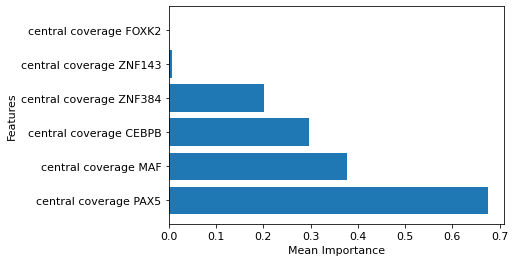

In [83]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

d = LR_central_fi.mean(axis=1).sort_values(ascending=False).head(6)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'central_coverage_FOXK2': 'central coverage FOXK2'})
print(d)

#plt.title('Logistic Regression with leave-one-out cross-validation')
plt.barh(d.index,d)
plt.xlabel('Mean Importance')
plt.ylabel('Features')

outfile = "thesis_plots/LogisticRegression_LOO_centralCoverage.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [84]:
LR_central_bootstrap, LR_central_fi = LR_bootstrap(scaled_data_central,False,1000,False,feature_central)

print('Accuracy: %.3f' % LR_central_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_central_bootstrap['auc'].mean())

Accuracy: 0.786
AUROC: 0.878


In [85]:
RF_central_bootstrap, RF_central_fi = RF_bootstrap(scaled_data_central,False,1000,False,feature_central)

print('Accuracy: %.3f' % RF_central_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_central_bootstrap['auc'].mean())

Accuracy: 0.774
AUROC: 0.871


In [86]:
#RF_central_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Mean cov:

In [87]:
LR_mean_loo, LR_mean_fi = LR_loo(scaled_data_mean,False,False,feature_mean)

LR_mean_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.0370370370370370...
accuracy                                             0.555556
auc                                                  0.515775
dtype: object

In [88]:
#LR_mean_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [89]:
LR_mean_bootstrap, LR_mean_fi = LR_bootstrap(scaled_data_mean,False,1000,False,feature_mean)

print('Accuracy: %.3f' % LR_mean_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mean_bootstrap['auc'].mean())

Accuracy: 0.486
AUROC: 0.478


In [90]:
RF_mean_bootstrap, RF_mean_fi = RF_bootstrap(scaled_data_mean,False,1000,False,feature_mean)

print('Accuracy: %.3f' % RF_mean_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mean_bootstrap['auc'].mean())

Accuracy: 0.519
AUROC: 0.581


In [91]:
#RF_mean_fi.mean(axis=1).sort_values(ascending=False).head(10)

# different scores

In [92]:
### WPS
cancer_type = "breast_cancer"
GC = "corrected"
score = "WPS"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

data_wps = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_wps = data_wps.columns[(data_wps.columns.str.startswith('central_cov')) | (data_wps.columns.str.startswith('mean_cov')) | (data_wps.columns.str.startswith('amplitude')) | (data_wps.columns.str.startswith('nucleosome_spacing'))]

scaled_data_wps = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_wps[features_wps])
scaled_data_wps[features_wps] = scaler.transform(scaled_data_wps[features_wps])
scaled_data_wps[features_wps].mean()

central_coverage_MSC           -4.746782e-15
mean_coverage_MSC              -7.087365e-12
amplitude190_MSC                2.298059e-15
nucleosome_spacing_fft_MSC      0.000000e+00
central_coverage_REL           -1.724444e-15
                                    ...     
nucleosome_spacing_fft_ZEB1     5.612794e-16
central_coverage_HOMEZ         -3.568133e-15
mean_coverage_HOMEZ             5.246386e-12
amplitude190_HOMEZ             -1.983399e-15
nucleosome_spacing_fft_HOMEZ    0.000000e+00
Length: 1508, dtype: float64

In [94]:
### COV
cancer_type = "breast_cancer"
GC = "corrected"
score = "COV"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

data_cov = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_cov = data_cov.columns[(data_cov.columns.str.startswith('central_cov')) | (data_cov.columns.str.startswith('mean_cov')) | (data_cov.columns.str.startswith('amplitude')) | (data_cov.columns.str.startswith('nucleosome_spacing'))]

scaled_data_cov = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_cov[features_cov])
scaled_data_cov[features_cov] = scaler.transform(scaled_data_cov[features_cov])
scaled_data_cov[features_cov].mean()

central_coverage_NFYC          -1.066534e-16
mean_coverage_NFYC             -7.420258e-13
amplitude190_NFYC              -1.500857e-16
nucleosome_spacing_fft_NFYC    -4.893205e-16
central_coverage_ATF7          -7.435924e-15
                                    ...     
nucleosome_spacing_fft_SIX5     1.387779e-17
central_coverage_NR5A2          2.611080e-15
mean_coverage_NR5A2             2.471317e-12
amplitude190_NR5A2              1.531697e-16
nucleosome_spacing_fft_NR5A2   -6.887495e-16
Length: 1508, dtype: float64

### WPS:

In [95]:
LR_wps_loo, LR_wps_fi = LR_loo(scaled_data_wps,False,False,features_wps)

LR_wps_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.2962962962962963...
accuracy                                             0.685185
auc                                                  0.830247
dtype: object

In [96]:
#LR_wps_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [97]:
LR_wps_bootstrap, LR_wps_fi = LR_bootstrap(scaled_data_wps,False,1000,False,features_wps)

print('Accuracy: %.3f' % LR_wps_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_wps_bootstrap['auc'].mean())

Accuracy: 0.718
AUROC: 0.803


In [98]:
RF_wps_bootstrap, RF_wps_fi = RF_bootstrap(scaled_data_wps,False,1000,False,features_wps)

print('Accuracy: %.3f' % RF_wps_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_wps_bootstrap['auc'].mean())

Accuracy: 0.749
AUROC: 0.852


In [99]:
#RF_wps_fi.mean(axis=1).sort_values(ascending=False).head(10)

### COV:

In [100]:
LR_cov_loo, LR_cov_fi = LR_loo(scaled_data_cov,False,False,features_cov)

LR_cov_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.6111111111111112...
accuracy                                             0.787037
auc                                                  0.883402
dtype: object

In [101]:
#LR_cov_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [102]:
LR_cov_bootstrap, LR_cov_fi = LR_bootstrap(scaled_data_cov,False,1000,False,features_cov)

print('Accuracy: %.3f' % LR_cov_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_cov_bootstrap['auc'].mean())

Accuracy: 0.757
AUROC: 0.846


In [103]:
RF_cov_bootstrap, RF_cov_fi = RF_bootstrap(scaled_data_cov,False,1000,False,features_cov)

print('Accuracy: %.3f' % RF_cov_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_cov_bootstrap['auc'].mean())

Accuracy: 0.773
AUROC: 0.857


In [104]:
#RF_cov_fi.mean(axis=1).sort_values(ascending=False).head(10)

# Plots

<Figure size 648x432 with 0 Axes>

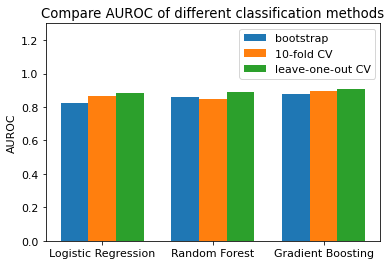

In [106]:
fig = plt.gcf()
fig.set_size_inches(9, 6)

methods = ("Logistic Regression", "Random Forest", "Gradient Boosting")
models = {
    'bootstrap': (lr_bootstrap_perf['auc'].mean(), rf_bootstrap_perf['auc'].mean(), gbc_bootstrap_perf['auc'].mean()),
    '10-fold CV': (lr_10fold_perf['auc'].mean(), rf_10fold_perf['auc'].mean(), gbc_10fold_perf['auc'].mean()),
    'leave-one-out CV': (lr_loo_perf['auc'].mean(), rf_loo_perf['auc'].mean(), gbc_loo_perf['auc'].mean()),
}

x = np.arange(len(methods))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.errorbar(x + offset, measurement, yerr=0.2, color="k", fmt="o")
    #ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_ylabel('AUROC')
ax.set_title('Compare AUROC of different classification methods')
#ax.set_xticks(x + width, methods)
plt.xticks(x+width, ['Logistic Regression', 'Random Forest', 'Gradient Boosting'])
ax.legend(loc='upper right')
ax.set_ylim(0, 1.3)

plt.show()

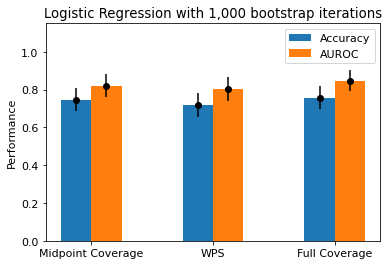

In [107]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

methods = ("Midpoint Coverage", "WPS", "Full Coverage")
models = {
    'Accuracy': (lr_bootstrap_perf['accuracy'].mean(), LR_wps_bootstrap['accuracy'].mean(), LR_cov_bootstrap['accuracy'].mean()),
    'AUROC': (lr_bootstrap_perf['auc'].mean(), LR_wps_bootstrap['auc'].mean(), LR_cov_bootstrap['auc'].mean()),
}
errors = {
    'Accuracy': (lr_bootstrap_perf['accuracy'].std(), LR_wps_bootstrap['accuracy'].std(), LR_cov_bootstrap['accuracy'].std()),
    'AUROC': (lr_bootstrap_perf['auc'].std(), LR_wps_bootstrap['auc'].std(), LR_cov_bootstrap['auc'].std()),
}

x = np.arange(len(methods))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots()

for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.errorbar(x + offset, measurement, yerr=errors[attribute], color="k", fmt="o")
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance')
ax.set_title('Logistic Regression with 1,000 bootstrap iterations')
#ax.set_xticks(x + width, methods)
plt.xticks(x+width, ["Midpoint Coverage", "WPS", "Full Coverage"])
ax.legend(loc='upper right')
ax.set_ylim(0, 1.15)

outfile = "thesis_plots/LogisticRegression_bootstrap_compareScores.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [108]:
extension="png"

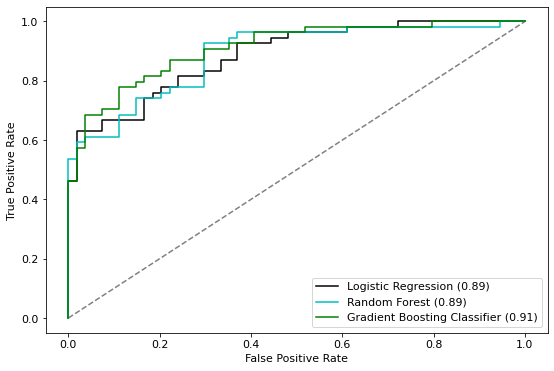

In [109]:
### COMPARE MODELS

fig = plt.gcf()
fig.set_size_inches(9, 6)


#plt.title('Receiver Operating Characteristic')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'Logistic Regression (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')  

plt.plot(rf_loo_perf['fpr'], rf_loo_perf['tpr'], 'c', label = 'Random Forest (%0.2f)' % rf_loo_perf['auc'])

plt.plot(gbc_loo_perf['fpr'], gbc_loo_perf['tpr'], 'g', label = 'Gradient Boosting Classifier (%0.2f)' % gbc_loo_perf['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LOO_compare_binary_classification."+extension
plt.savefig(outfile)

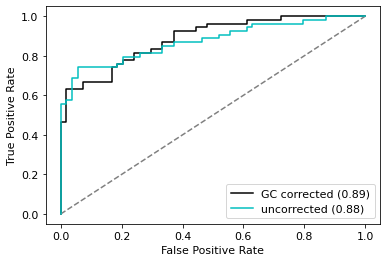

In [110]:
### CORRECTION

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

#plt.title('Receiver Operating Characteristic')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'GC corrected (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
plt.plot(LR_uncorrected_loo['fpr'], LR_uncorrected_loo['tpr'], 'c', label = 'uncorrected (%0.2f)' % LR_uncorrected_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_correction."+extension
plt.savefig(outfile)

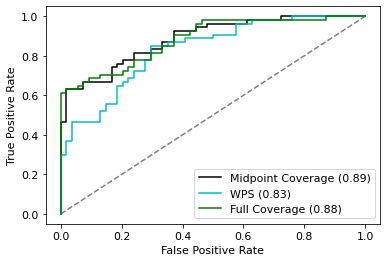

In [111]:
### DIFFERENT SCORES

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

#plt.title('ROC Curve of Logistic Regression with leave-one-out CV')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'Midpoint Coverage (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_wps_loo['fpr'], LR_wps_loo['tpr'], 'c', label = 'WPS (%0.2f)' % LR_wps_loo['auc'])

plt.plot(LR_cov_loo['fpr'], LR_cov_loo['tpr'], 'g', label = 'Full Coverage (%0.2f)' % LR_cov_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_scores."+extension
plt.savefig(outfile)

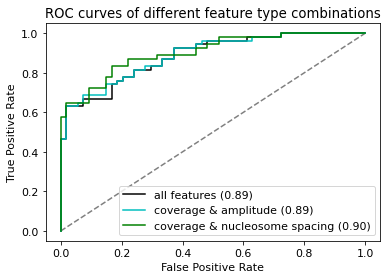

In [112]:
### 3 FEATURES

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

plt.title('ROC curves of different feature type combinations')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'all features (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_griffin_loo['fpr'], LR_griffin_loo['tpr'], 'c', label = 'coverage & amplitude (%0.2f)' % LR_griffin_loo['auc'])

plt.plot(LR_mix_loo['fpr'], LR_mix_loo['tpr'], 'g', label = 'coverage & nucleosome spacing (%0.2f)' % LR_mix_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_3features."+extension
plt.savefig(outfile)

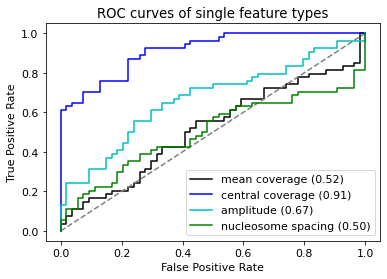

In [113]:
### SINGLE FEATURES

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)


plt.title('ROC curves of single feature types')
plt.plot(LR_mean_loo['fpr'], LR_mean_loo['tpr'], 'k', label = 'mean coverage (%0.2f)' % LR_mean_loo['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_central_loo['fpr'], LR_central_loo['tpr'], 'b', label = 'central coverage (%0.2f)' % LR_central_loo['auc'])

plt.plot(LR_amplitude_loo['fpr'], LR_amplitude_loo['tpr'], 'c', label = 'amplitude (%0.2f)' % LR_amplitude_loo['auc'])

plt.plot(LR_mine_loo['fpr'], LR_mine_loo['tpr'], 'g', label = 'nucleosome spacing (%0.2f)' % LR_mine_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_single_features."+extension
plt.savefig(outfile)